In [1]:
import gym
import numpy as np
import sys
from gym.envs.toy_text import discrete
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
np.random.seed(0)

[2017-02-27 13:33:55,550] You have 'numpy' version 1.10.1 installed, but 'gym' requires at least 1.10.4. HINT: upgrade via 'pip install -U numpy'.


In [17]:
import itertools

In [2]:
class RandomWalk(discrete.DiscreteEnv):
    metadata = {'render.modes':['human','ansi']}
    def __init__(self):
        self.shape = (7,)
        nS = np.prod(self.shape)
        nA = 2
        # calculate transition probabilities
        self.LEFT = 0
        self.RIGHT = 1
        P = {}
        for s in range(nS):
            P[s] = {a : [] for a in range(nA) }
            # observation, new_state, reward, is_done
            P[s][self.LEFT] = [(1.0, max(0, s-1), 0, True if max(0, s-1) == 0 else False)]
            P[s][self.RIGHT] = [(1.0, min(nS-1, s+1), 0, True if min(nS-1,s+1) == (nS-1) else False)]
        # the transition from E to RT is 1
        P[5][self.RIGHT] = [(1.0, 6, 1, True)]
        
        # we always start in state C (which is 3)
        isd = np.zeros(nS)
        isd[3] = 1.0
        
        super(RandomWalk, self).__init__(nS, nA, P, isd)
        
    def _step(self, a):
        transitions = self.P[self.s][a]
        p, s, r, d = transitions[0]
        self.s = s
        self.lastaction=a
        return (s, r, d, {"prob" : p})
    
    def _render(self, mode='human', close=False):
        if close:
            return
        outfile = StringIO() if mode == 'ansi' else sys.stdout
        st = ['LT', 'A', 'B', 'C', 'D', 'E', 'RT']
        st[self.s] = '(' + st[self.s] + ')'
        outfile.write(" ".join(st))
        outfile.write("\n")

Test the game when we go all left

In [8]:
env = RandomWalk()
env.render()
print env.step(0)
env.render()
print env.step(0)
env.render()

LT A B (C) D E RT
(2, 0, False, {'prob': 1.0})
LT A (B) C D E RT
(1, 0, False, {'prob': 1.0})
LT (A) B C D E RT


Test the game when we go all right

In [14]:
env = RandomWalk()
env.render()
print env.step(1)
env.render()
print env.step(1)
env.render()
print env.step(1)

LT A B (C) D E RT
(4, 0, False, {'prob': 1.0})
LT A B C (D) E RT
(5, 0, False, {'prob': 1.0})
LT A B C D (E) RT
(6, 1, True, {'prob': 1.0})


-------

We present the algorithm for an n-step policy evaluation

In [237]:
def n_step_td_estimate(env, policy, num_episodes, alpha, gamma, n, debug=False):
    # intialise V(s) arbitrarily
    V = np.zeros(env.nS)
    # repeat for each episode
    for num_episode in range(num_episodes):
        if debug:
            print "iter:", num_episode
        env.reset()
        T = np.inf
        rewards = dict() # TODO: not efficient
        states = dict()
        states[0] = env.s
        for t in itertools.count():
            #print t, states, V
            if t < T:
                # take an action according to the policy
                action = policy(env.s)
                _, R, is_done, _ = env.step(action)
                # observe and store the next reward as R_{t+1}, and the next state as S_{t+1}
                rewards[t+1] = R
                states[t+1] = env.s
                # if S_{t+1} is terminal, then T = t - 1
                if is_done:
                    T = t+1
            tau = t - n + 1
            #print tau
            if tau >= 0:
                if debug:
                    print "updating state %i," % states[tau],
                G = 0
                for i in range(tau+1, min(tau+n, T)+1):
                    G += ((gamma**(i-tau-1))*rewards[i])
                if tau + n < T:
                    G = G + (gamma**n)*V[ states[tau+n] ]
                if debug:
                    print "G = %i," % G,
                    print "V of state %i is %f" % (states[tau], V[states[tau]])
                V[ states[tau] ] += alpha*(G - V[ states[tau] ])
            if tau == T-1:
                break
    if debug:
        print
    return V

If we're following an always-right-walk policy, we expect that all states to the right of C receive a value of 1 (since whenever we are in these states, we will move right eventually hitting the terminal with a reward of 1)

In [119]:
def right_walk_policy(state):
    LEFT, RIGHT = 0, 1
    return RIGHT

In [121]:
n_step_td_estimate(env=RandomWalk(), policy=right_walk_policy, num_iters=100, alpha=0.5, gamma=1, n=2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


array([ 0.,  0.,  0.,  1.,  1.,  1.,  0.])

In [137]:
def left_walk_policy(state):
    LEFT, RIGHT = 0, 1
    return LEFT

In [138]:
n_step_td_estimate(env=RandomWalk(), policy=left_walk_policy, num_iters=100, alpha=0.5, gamma=1, n=2)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.])

Let us try a random walk policy with $n=2$ and $n=1$:

In [130]:
def random_policy(state):
    LEFT, RIGHT = 0, 1
    if np.random.randint(0,2) == 0:
        return LEFT
    else:
        return RIGHT

$n = 2$:

In [174]:
np.random.seed(0)
V = n_step_td_estimate(env=RandomWalk(), policy=random_policy, num_iters=10000, alpha=0.01, gamma=1, n=2)
print V[ [1,2,3,4,5] ]

[ 0.18261455  0.34008082  0.49672043  0.66335435  0.83086432]


From the textbook, the real values are (1/6, 2/6, 3/6, 4/6, and 5/6) for A, B, C, D, and E, respectively, so let's check that:

In [175]:
print [1.0/6, 2.0/6, 3.0/6, 4.0/6, 5.0/6]

[0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334]


$n = 1$:

In [176]:
np.random.seed(0)
V = n_step_td_estimate(env=RandomWalk(), policy=random_policy, num_iters=10000, alpha=0.01, gamma=1, n=1)
print V[ [1,2,3,4,5] ]

[ 0.17417513  0.33827588  0.49017577  0.66800682  0.83955003]


----

From the textbook, "a one-step method would change only the estimate for the last state, V(E), which would be incremented toward 1, the observed return". This is because we go from C to D (immediate reward = 0), from D to E ( immediate reward = 0), and E to terminal (immediate reward = 1), so E only gets updated.

In [201]:
V = n_step_td_estimate(env=RandomWalk(), policy=right_walk_policy, num_iters=1, alpha=0.01, gamma=1, n=1, debug=True)
print V

iter: 0
updating state 3, G = 0, V of state 3 is 0.000000
updating state 4, G = 0, V of state 4 is 0.000000
updating state 5, G = 1, V of state 5 is 0.000000

[ 0.    0.    0.    0.    0.    0.01  0.  ]


...where state 3 = 'C', state 4 = 'D', and state 5 = 'E'

From the textbook, "a two step method, on the other hand, would increment the values of the two states preceding termination: V(D) and V(E)". This is because the immediate reward from D to the terminal state is 1, and also because the immediate reward from E to the terminal state is 1

In [206]:
V = n_step_td_estimate(env=RandomWalk(), policy=right_walk_policy, num_iters=1, alpha=0.01, gamma=1, n=2, debug=True)
print V

iter: 0
updating state 3, G = 0, V of state 3 is 0.000000
updating state 4, G = 1, V of state 4 is 0.000000
updating state 5, G = 1, V of state 5 is 0.000000

[ 0.    0.    0.    0.    0.01  0.01  0.  ]


-------

We can see that there is a trade-off to be made for $n$: in the extreme case, we perform Monte-Carlo updates, and then we perform updates on the state values extremely late (i.e. after we have hit the terminal state). In the other extreme case ($n=1$), we perform updates after single steps, which doesn't seem all that ideal, since we are computing updates based on very little information (in this case, simply the immedate reward, $R_{t+1}$), and the estimated value for $S_{t+1}$.

In [282]:
class ExtremeRandomWalk(discrete.DiscreteEnv):
    metadata = {'render.modes':['human','ansi']}
    def __init__(self):
        num_states = 19
        self.shape = (num_states,)
        nS = np.prod(self.shape)
        nA = 2
        # calculate transition probabilities
        self.LEFT = 0
        self.RIGHT = 1
        P = {}
        for s in range(nS):
            P[s] = {a : [] for a in range(nA) }
            # observation, new_state, reward, is_done
            P[s][self.LEFT] = [(1.0, max(0, s-1), 0, True if max(0, s-1) == 0 else False)]
            P[s][self.RIGHT] = [(1.0, min(nS-1, s+1), 0, True if min(nS-1,s+1) == (nS-1) else False)]
        # the transition from the left-most state to the left terminal is a reward of 1
        P[1][self.LEFT] = [(1.0, 0, 1, True)]
        
        # we always start in state C (which is 3)
        isd = np.zeros(nS)
        isd[9] = 1.0
        
        super(ExtremeRandomWalk, self).__init__(nS, nA, P, isd)
        
    def _step(self, a):
        transitions = self.P[self.s][a]
        p, s, r, d = transitions[0]
        self.s = s
        self.lastaction=a
        return (s, r, d, {"prob" : p})
    
    def _render(self, mode='human', close=False):
        if close:
            return
        outfile = StringIO() if mode == 'ansi' else sys.stdout
        st = [ str(x) for x in range(self.nS) ]
        st[self.s] = '(' + st[self.s] + ')'
        outfile.write(" ".join(st))
        outfile.write("\n")

In [312]:
tmp=ExtremeRandomWalk()
real_vals = []
for i in range(1, tmp.nS-2+1):
    real_vals.append( (i*1.0) / (tmp.nS-1) )
real_vals = [0] + real_vals[::-1] + [0]
real_vals = np.asarray(real_vals)
print real_vals

[ 0.          0.94444444  0.88888889  0.83333333  0.77777778  0.72222222
  0.66666667  0.61111111  0.55555556  0.5         0.44444444  0.38888889
  0.33333333  0.27777778  0.22222222  0.16666667  0.11111111  0.05555556
  0.        ]


In [336]:
mses = []
for n in range(1, env.nS):
    V = np.zeros(tmp.nS)
    num_repeats = 100
    for repeat in range(num_repeats):
        V += n_step_td_estimate(env=ExtremeRandomWalk(), policy=random_policy, num_episodes=10, alpha=0.01, gamma=1, n=n, debug=False)
    V = np.sum(V, axis=0) / num_repeats
    mse = np.mean((V - real_vals)**2)
    print n, mse
    mses.append(mse)

1 0.249317645224
2 0.208274428675
3 0.179403925484
4 0.147520342963
5 0.129283483399
6 0.1112906734
7 0.0988563961121
8 0.0944361213997
9 0.0900622712431
10 0.0936641192097
11 0.103183547782
12 0.109970136606
13 0.126749801925
14 0.13945249649
15 0.19002149287
16 0.200376455816
17 0.194688233
18 0.248180260762


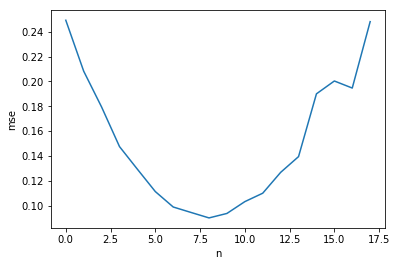

In [338]:
plt.plot(mses)
plt.xlabel("n")
plt.ylabel("mse")

In [333]:
np.mean((V - real_vals)**2)

0.12728053037252715